# 0. Data setup

In [54]:
import os
import glob
import numpy as np
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu130
CUDA available: True


In [55]:
get_path = os.environ.get("UNI_PATH") # αυτό ειναι δικό μου, comment it out
DATA_PATH = Path(get_path).resolve()

# Dataset root
CITYSCAPES_ROOT = DATA_PATH / "Datasets" / "CityScapes5000"

# Image and label directories
IMAGES_DIR = CITYSCAPES_ROOT / "leftImg8bit"
LABELS_DIR = CITYSCAPES_ROOT / "gtFine"

print("=" * 60)
print("DATASET PATHS")

# print("=" * 60)
# print(f"Cityscapes root: {CITYSCAPES_ROOT}")
# print(f"  Exists: {CITYSCAPES_ROOT.exists()}")

# print(f"\nImages dir: {IMAGES_DIR}")
# print(f"  Exists: {IMAGES_DIR.exists()}")

# print(f"\nLabels dir: {LABELS_DIR}")
# print(f"  Exists: {LABELS_DIR.exists()}")

DATASET PATHS


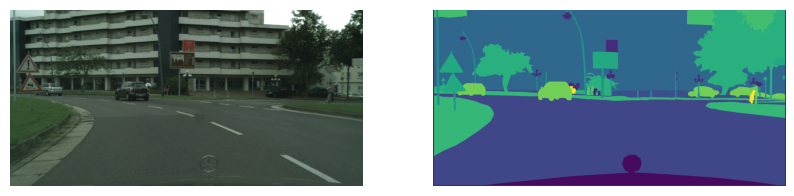

In [56]:
first_img_path = IMAGES_DIR / "train" / "aachen" / "aachen_000000_000019_leftImg8bit.png"
first_img_path_label = LABELS_DIR / "train" / "aachen" / "aachen_000000_000019_gtFine_labelIds.png"
first_img = Image.open(first_img_path)
first_img_label = Image.open(first_img_path_label)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(first_img)
ax[1].imshow(first_img_label)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

## 0.1 Inspections

In [57]:
print("label shape: ", np.array(first_img_label).shape, "img shape: ", np.array(first_img).shape)

# inspect the label
first_img_label_array = np.array(first_img_label)
print("Number of classes in first image: ", len(np.unique(first_img_label_array)), "\nClasses: ", np.unique(first_img_label_array))


label shape:  (1024, 2048) img shape:  (1024, 2048, 3)
Number of classes in first image:  16 
Classes:  [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


## 0.2 Changing label IDs

In [58]:
# cityscapesscripts
# labels.py

# class mapping coding block
TRAIN_ID_MAP = {
    0: 255,  # unlabeled -> ignore
    1: 255,  # ego vehicle -> ignore
    2: 255,  # rectification border -> ignore
    3: 255,  # out of roi -> ignore
    4: 255,  # static -> ignore
    5: 255,  # dynamic -> ignore
    6: 255,  # ground -> ignore
    7: 0,    # road
    8: 1,    # sidewalk
    9: 255,  # parking -> ignore
    10: 255, # rail track -> ignore
    11: 2,   # building
    12: 3,   # wall
    13: 4,   # fence
    14: 255, # guard rail -> ignore
    15: 255, # bridge -> ignore
    16: 255, # tunnel -> ignore
    17: 5,   # pole
    18: 255, # polegroup -> ignore
    19: 6,   # traffic light
    20: 7,   # traffic sign
    21: 8,   # vegetation
    22: 9,   # terrain
    23: 10,  # sky
    24: 11,  # person
    25: 12,  # rider
    26: 13,  # car
    27: 14,  # truck
    28: 15,  # bus
    29: 255, # caravan -> ignore
    30: 255, # trailer -> ignore
    31: 16,  # train
    32: 17,  # motorcycle
    33: 18,  # bicycle
    -1: 255, # license plate -> ignore
}

# Training class names (19 classes)
TRAIN_CLASSES = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
    'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle'
]

NUM_CLASSES = 19  # Standard Cityscapes training classes
IGNORE_INDEX = 255  # Label to ignore during training


In [59]:
def count_images(split):
    """Count images in a split across all cities."""
    img_dir = IMAGES_DIR / split
    if not img_dir.exists():
        return 0, []
    
    images = []
    for city_dir in img_dir.iterdir():
        if city_dir.is_dir():
            city_images = list(city_dir.glob("*_leftImg8bit.png"))
            images.extend(city_images)
    return len(images), images


train_count, train_images = count_images('train')
val_count, val_images = count_images('val')
test_count, test_images = count_images('test')

print(f"Train: {train_count} images")
print(f"Val:   {val_count} images")
print(f"Test:  {test_count} images")
print(f"Total: {train_count + val_count + test_count} images")

Train: 2975 images
Val:   500 images
Test:  1525 images
Total: 5000 images


Image shape:  (1024, 2048, 3)
Image size: (2048, 1024)
Image mode: RGB

Label IDs size: (2048, 1024)
Label IDs mode: L

Label ID dtype: uint8
Label ID range: [0, 33]
Unique labels in this image: 16
Label values: [0, 1, 3, 4, 7, 8, 11, 17, 20, 21, 22, 23, 24, 25, 26, 33]


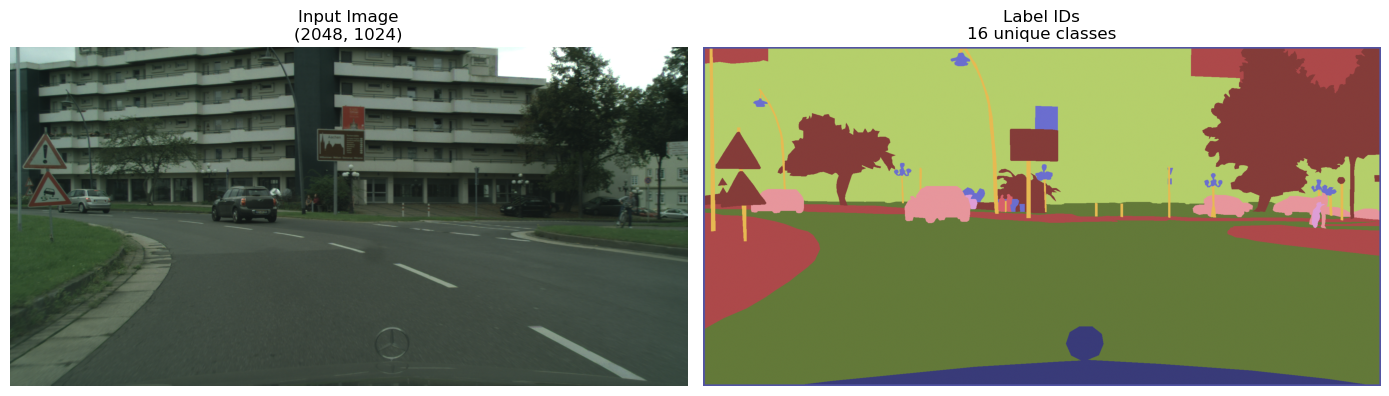

In [60]:
# opening first image and label
if train_images:
    sample_img_path = train_images[0]
    city = sample_img_path.parent.name
    base_name = sample_img_path.stem.replace('_leftImg8bit', '')
    
    label_ids_path = LABELS_DIR / 'train' / city / f"{base_name}_gtFine_labelIds.png"
    
    sample_img = Image.open(sample_img_path)
    label_ids = Image.open(label_ids_path)
    
    print("Image shape: ", np.array(sample_img).shape)
    print(f"Image size: {sample_img.size}")
    print(f"Image mode: {sample_img.mode}")
    print(f"\nLabel IDs size: {label_ids.size}")
    print(f"Label IDs mode: {label_ids.mode}")
    
    # Analyze label values
    label_array = np.array(label_ids)
    unique_labels = np.unique(label_array)
    print(f"\nLabel ID dtype: {label_array.dtype}")
    print(f"Label ID range: [{label_array.min()}, {label_array.max()}]")
    print(f"Unique labels in this image: {len(unique_labels)}")
    print(f"Label values: {unique_labels.tolist()}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(sample_img)
    axes[0].set_title(f"Input Image\n{sample_img.size}")
    axes[0].axis('off')
    
    axes[1].imshow(label_array, cmap='tab20b')
    axes[1].set_title(f"Label IDs\n{len(unique_labels)} unique classes")
    axes[1].axis('off')

    
    plt.tight_layout()
    plt.show()

# 1. PyTorch Dataset Class

In [61]:
import torch
from torch.utils.data import Dataset, DataLoader


class CityscapesDataset(Dataset):
    """
    PyTorch Dataset for official Cityscapes format.
    
    Loads images from leftImg8bit/ and labels from gtFine/*_labelIds.png
    """
    
    def __init__(self, root_dir, split='train', img_size=(512, 256), 
                 use_train_ids=True, transform=None):
        """
        Args:
            root_dir: Path to Cityscapes root (contains leftImg8bit/ and gtFine/)
            split: 'train', 'val', or 'test'
            img_size: Tuple (width, height) for resizing
            use_train_ids: If True, map 34 classes to 19 training classes
            transform: Optional transforms for augmentation
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.img_width, self.img_height = img_size
        self.use_train_ids = use_train_ids
        self.transform = transform
        
        # Collect all image paths
        self.images = []
        self.labels = []
        
        img_dir = self.root_dir / "leftImg8bit" / split
        label_dir = self.root_dir / "gtFine" / split
        
        for city_dir in sorted(img_dir.iterdir()):
            if city_dir.is_dir():
                city = city_dir.name
                for img_path in sorted(city_dir.glob("*_leftImg8bit.png")):
                    base_name = img_path.stem.replace('_leftImg8bit', '')
                    label_path = label_dir / city / f"{base_name}_gtFine_labelIds.png"
                    
                    if label_path.exists():
                        self.images.append(img_path)
                        self.labels.append(label_path)
        
        print(f"  Found {len(self.images)} image-label pairs in {split}")
    
    def __len__(self):
        return len(self.images)
    
    def _map_to_train_ids(self, label):
        """Map original label IDs (0-33) to training IDs (0-18, 255=ignore)"""
        label_copy = label.copy()
        for orig_id, train_id in TRAIN_ID_MAP.items():
            label_copy[label == orig_id] = train_id
        return label_copy
    
    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.images[idx]).convert('RGB')
        
        # Load label (as single channel)
        label = Image.open(self.labels[idx])
        
        # Resize
        img = img.resize((self.img_width, self.img_height), Image.BILINEAR)
        label = label.resize((self.img_width, self.img_height), Image.NEAREST)
        
        # Convert to numpy
        img_array = np.array(img)
        label_array = np.array(label, dtype=np.int64)
        
        # Map to training IDs if requested
        if self.use_train_ids:
            label_array = self._map_to_train_ids(label_array)
        
        # Apply transforms (if any)
        if self.transform:
            augmented = self.transform(image=img_array, mask=label_array)
            img_array = augmented["image"]
            label_array = augmented["mask"]     

        # Convert to tensor
        # img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
        img_tensor = img_array
        label_tensor = label_array.long()
        
        return img_tensor, label_tensor

### Albumentations or other random transforms.
# might need permutations

###  Ideas: 
1. function to measure resizing error + put metrics after resizing to put on final paper + a bit of bibliography research if needed for SSIM and other metrics
2. try inference on validation and test set in higher resolution

In [62]:
# Count cores
import platform
import os


num_cores = os.cpu_count()
print(f"CPU cores: {num_cores}")



if platform.system() == 'Windows':
    print("Windows detected")
    NUM_WORKERS = 0  # or 1
else:
    print("Linux/Mac detected")
    NUM_WORKERS = 4  # Linux/Mac

CPU cores: 20
Linux/Mac detected


## 1.1 Transformations: Used ImgeNet mean and std for now 

In [63]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tf = A.Compose([
    # A.Resize(256, 512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225]),
    ToTensorV2()
])

val_tf = A.Compose([
    # A.Resize(256, 512),
    A.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225]),
    ToTensorV2()
])

## 1.2 Creating loaders

In [64]:
# Configuration
IMG_SIZE = (512, 256)  # (width, height) - Cityscapes aspect ratio
BATCH_SIZE = 4    # big

# here we define the transforms. We also have to decide what transform to put for each set. ToTensor might be one of them.


train_dataset = CityscapesDataset(CITYSCAPES_ROOT, split='train', img_size=IMG_SIZE, transform=train_tf, use_train_ids=True)
val_dataset = CityscapesDataset(CITYSCAPES_ROOT, split='val', img_size=IMG_SIZE, transform=val_tf, use_train_ids=True)
test_dataset = CityscapesDataset(CITYSCAPES_ROOT, split='test', img_size=IMG_SIZE, transform=val_tf, use_train_ids=True)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

print("DATASET SUMMARY")
print("=" * 60)
print(f"Image size: {IMG_SIZE[0]} x {IMG_SIZE[1]} (W x H)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"\nTrain: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"\nVal:   {len(val_dataset)} images, {len(val_loader)} batches")
print(f"\nTest:  {len(test_dataset)} images, {len(test_loader)} batches")

  Found 2975 image-label pairs in train
  Found 500 image-label pairs in val
  Found 1525 image-label pairs in test
Using device: cuda

DATASET SUMMARY
Image size: 512 x 256 (W x H)
Batch size: 4
Number of classes: 19

Train: 2975 images, 744 batches

Val:   500 images, 125 batches

Test:  1525 images, 382 batches


In [65]:
## tests on shapes
img, mask = train_dataset[0]

print(img.shape)        # [3, H, W]
print(img.dtype)       # torch.float32
print(mask.shape)      # [H, W]
print(mask.dtype)      # torch.int64
print(torch.unique(mask))


torch.Size([3, 256, 512])
torch.float32
torch.Size([256, 512])
torch.int64
tensor([  0,   1,   2,   5,   7,   8,   9,  10,  11,  12,  13,  18, 255])


In [66]:
img, label = train_loader.dataset[0]
print(img.shape)
print(label.shape)


torch.Size([3, 256, 512])
torch.Size([256, 512])


In [67]:
len(train_dataset), len(train_loader), BATCH_SIZE, BATCH_SIZE * len(train_loader)

(2975, 744, 4, 2976)

In [68]:
# Quick test - compare 2 vs 4 workers
import time

def quick_test(num_workers):
    loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True)
    start = time.time()
    for i, _ in enumerate(loader):
        if i >= 10: break
    return time.time() - start

time_2 = quick_test(2)
time_4 = quick_test(4)
print(f"2 workers: {time_2:.2f}s")
print(f"4 workers: {time_4:.2f}s")
print(f"Speedup: {time_2/time_4:.2f}×")

2 workers: 4.08s
4 workers: 5.04s
Speedup: 0.81×


In [69]:
images, labels = next(iter(train_loader))
images.shape, labels.shape


(torch.Size([4, 3, 256, 512]), torch.Size([4, 256, 512]))

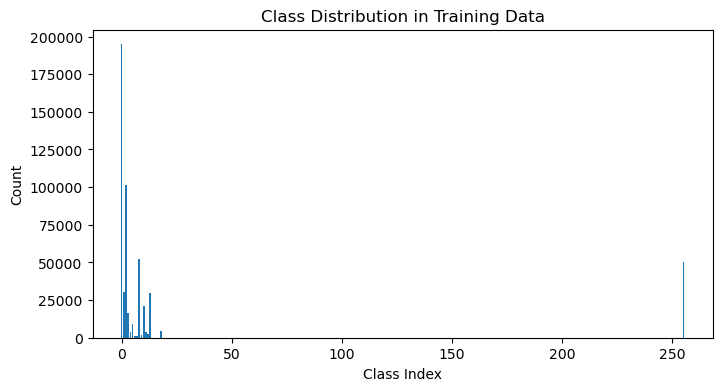

In [70]:
unique_labels, counts = torch.unique(labels, return_counts=True)

unique_labels_np = unique_labels.cpu().numpy()
counts_np = counts.cpu().numpy()

plt.figure(figsize=(8, 4))
plt.bar(unique_labels_np, counts_np)
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')
plt.show()


### Add more code to visualize and see stats of class distribution

# 2. U-Net Architecture From Scratch (but different padding than OG(2015) paper)

In [71]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
      
    def forward(self, x):
        return self.conv(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2) #or bilinear interpolation upsampling
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2): # in forward pass x1 is the upsampled image and x2 is the skip connection from the encoder
        x1 = self.up(x1)       # could add safety checks for size differences
        x = torch.cat([x1, x2], 1)
        x = self.conv(x)
        return x


class UNET(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)
        
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

# 3. Training loop

In [72]:
MODEL_SAVE_PATH = DATA_PATH / "MachineLearning" / "models" 
MODEL_SAVE_PATH.parent.exists()

True

In [73]:


LEARNING_RATE = 4e-4
EPOCHS = 8
NUM_CLASSES = 19

if not device:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")


Using device: cuda



In [74]:
import torch.optim as optim


model = UNET(in_channels=3, num_classes=NUM_CLASSES).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# OneCycleLR
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=8e-3, 
    steps_per_epoch=len(train_loader), 
    epochs=12
)

In [76]:
from tqdm.auto import tqdm
import sys
import os

sys.path.append(os.path.abspath('..')) # Adjust path if needed
from src.metrics import IoUMetric, PrecisionRecallMetric, DiceScoreMetric
import torch
import torch.optim as optim
import copy
from tqdm.auto import tqdm




ImportError: cannot import name 'DiceScoreMetric' from 'src.metrics' (/mnt/c/Users/johnh/Desktop/simantik/METAPTYXIAKO assignments/MachineLearning/src/metrics.py)

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    if metrics:
        if not isinstance(metrics, list): metrics = [metrics]
        for m in metrics:
            m.reset()
    # Wrap loader in tqdm for the progress bar
    pbar = tqdm(loader, desc="Training", leave=False)

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item()
        # Update metrics (using detach() to save memory)
        if metrics:
            with torch.no_grad():
                for m in metrics:
                    m.update(outputs.detach(), labels.detach())
        # Update progress bar description with current loss
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    epochs_loss = running_loss / len(loader)
    
    # Compute final metrics
    metric_results = {}
    if metrics:
        for m in metrics:
            # Use class name or a custom name key
            metric_results[m.__class__.__name__] = m.compute()
            
    return epochs_loss, metric_results

# --- 1. Helper Function for Validation ---
def validate_epoch(model, loader, criterion, device, metrics=None):
    model.eval()
    running_loss = 0.0
    
    # Reset metrics
    if metrics:
        if not isinstance(metrics, list): metrics = [metrics]
        for m in metrics:
            m.reset()
            
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Update metrics
            if metrics:
                for m in metrics:
                    m.update(outputs, labels)
                    
    epoch_loss = running_loss / len(loader)
    
    # Compute metrics
    metric_results = {}
    if metrics:
        for m in metrics:
            metric_results[m.__class__.__name__] = m.compute()
            
    return epoch_loss, metric_results

In [ ]:
from transformers import SegformerForSemanticSegmentation
import torch.nn as nn

class SegFormer(nn.Module):
    def __init__(self, num_classes, pretrained_model_name="nvidia/mit-b0"):
        super().__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            pretrained_model_name, 
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
    def forward(self, x):
        # Segformer expects pixel_values argument
        outputs = self.model(pixel_values=x)
        logits = outputs.logits
        
        # Upsample logits to match input image size (B, C, H, W)
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=x.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )
        return upsampled_logits

In [ ]:
from tqdm.auto import tqdm
import torch

def train_epoch(model, loader, optimizer, criterion, device, scheduler=None, metrics=None):
    model.train()
    running_loss = 0.0

    # Reset metrics at start of epoch
    if metrics:
        if not isinstance(metrics, list): metrics = [metrics]
        for m in metrics:
            m.reset()

    # Wrap loader in tqdm for the progress bar
    pbar = tqdm(loader, desc="Training", leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step scheduler
        if scheduler:
            scheduler.step()

        running_loss += loss.item()
        
        # Update metrics (using detach() to save memory)
        if metrics:
            with torch.no_grad():
                for m in metrics:
                    m.update(outputs.detach(), labels.detach())

        # Update progress bar description with current loss
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    epochs_loss = running_loss / len(loader)
    
    # Compute final metrics
    metric_results = {}
    if metrics:
        for m in metrics:
            # Use class name or a custom name key
            metric_results[m.__class__.__name__] = m.compute()
            
    return epochs_loss, metric_results

In [78]:
import torch.optim as optim
import pandas as pd

# --- Configuration ---
MODELS = {
    'UNet': UNET(in_channels=3, num_classes=NUM_CLASSES),
    'SegFormer': SegFormer(num_classes=NUM_CLASSES, pretrained_model_name="nvidia/mit-b0")
}

LR = 1e-4
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index=255)

results_summary = []
histories = {}

print(f"Starting comparison on device: {device}")

for name, model_instance in MODELS.items():
    print(f"\n" + "="*40)
    print(f"Training {name}...")
    print("="*40)
    
    model = model_instance.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS
    )
    
    # Metrics
    metrics_train = [
        IoUMetric(NUM_CLASSES, ignore_index=255),
        DiceScoreMetric(NUM_CLASSES, ignore_index=255)
    ]
    metrics_val = [
        IoUMetric(NUM_CLASSES, ignore_index=255),
        DiceScoreMetric(NUM_CLASSES, ignore_index=255)
    ]
    
    history = {'train_loss': [], 'val_loss': [], 'val_miou': [], 'val_dice': []}
    best_score = 0.0
    
    for epoch in range(NUM_EPOCHS):
        # TRAIN
        t_loss, t_res = train_epoch(model, train_loader, optimizer, criterion, device, 
                                    scheduler=scheduler, metrics=metrics_train)
        
        # VALIDATE
        v_loss, v_res = validate_epoch(model, val_loader, criterion, device, 
                                       metrics=metrics_val)
        
        # Log
        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['val_miou'].append(v_res['IoUMetric'])
        history['val_dice'].append(v_res['DiceScoreMetric'])
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Val Loss: {v_loss:.4f} | mIoU: {v_res['IoUMetric']:.4f} | Dice: {v_res['DiceScoreMetric']:.4f}")
        
        # Save Best
        current_score = v_res['IoUMetric']
        if current_score > best_score:
            best_score = current_score
            torch.save(model.state_dict(), f"best_model_{name}.pth")
            
    histories[name] = history
    results_summary.append({
        'Model': name, 
        'Best mIoU': best_score,
        'Final Dice': history['val_dice'][-1]
    })

print("\nExperiment Complete!")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting comparison on device: cuda

Training UNet...


Epoch 1/10 | Val Loss: 1.2602 | mIoU: 0.2020 | Dice: 0.2445


Epoch 2/10 | Val Loss: 0.7651 | mIoU: 0.2310 | Dice: 0.2746


Epoch 3/10 | Val Loss: 0.5979 | mIoU: 0.2594 | Dice: 0.3079


Epoch 4/10 | Val Loss: 0.4676 | mIoU: 0.2971 | Dice: 0.3486


Epoch 5/10 | Val Loss: 0.4164 | mIoU: 0.3245 | Dice: 0.3895


Epoch 6/10 | Val Loss: 0.3805 | mIoU: 0.3585 | Dice: 0.4329


Epoch 7/10 | Val Loss: 0.3474 | mIoU: 0.3746 | Dice: 0.4522


Epoch 8/10 | Val Loss: 0.3400 | mIoU: 0.3844 | Dice: 0.4642


Epoch 9/10 | Val Loss: 0.3126 | mIoU: 0.3991 | Dice: 0.4786


Epoch 10/10 | Val Loss: 0.3112 | mIoU: 0.3993 | Dice: 0.4787

Training SegFormer...


Epoch 1/10 | Val Loss: 0.7569 | mIoU: 0.2317 | Dice: 0.2719


Epoch 2/10 | Val Loss: 0.4426 | mIoU: 0.3002 | Dice: 0.3567


Epoch 3/10 | Val Loss: 0.3467 | mIoU: 0.3811 | Dice: 0.4662


Epoch 4/10 | Val Loss: 0.3070 | mIoU: 0.4405 | Dice: 0.5493


Epoch 5/10 | Val Loss: 0.2808 | mIoU: 0.4847 | Dice: 0.6031


Epoch 6/10 | Val Loss: 0.2719 | mIoU: 0.5112 | Dice: 0.6377


Epoch 7/10 | Val Loss: 0.2616 | mIoU: 0.5325 | Dice: 0.6602


Epoch 8/10 | Val Loss: 0.2568 | mIoU: 0.5348 | Dice: 0.6627


Epoch 9/10 | Val Loss: 0.2537 | mIoU: 0.5441 | Dice: 0.6732


Epoch 10/10 | Val Loss: 0.2522 | mIoU: 0.5447 | Dice: 0.6736

Experiment Complete!


In [ ]:
# import torch.optim as optim
# import pandas as pd

# # Define Models to Compare
# MODELS_TO_TEST = {
#     'UNet': UNET(in_channels=3, num_classes=NUM_CLASSES),
#     'SegFormer': SegFormer(num_classes=NUM_CLASSES, pretrained_model_name="nvidia/mit-b0")
# }

# # Hyperparameters
# LR = 1e-4 
# NUM_EPOCHS = 10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion = nn.CrossEntropyLoss(ignore_index=255)

# model_results = []
# histories = {} 

# print(f"Comparing Models: {list(MODELS_TO_TEST.keys())}")

# for model_name, model_instance in MODELS_TO_TEST.items():
#     print(f"\n" + "="*40)
#     print(f"Training Model: {model_name}")
#     print("="*40)
    
#     # Setup
#     model = model_instance.to(device)
#     optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
#     scheduler = optim.lr_scheduler.OneCycleLR(
#         optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS
#     )
    
#     # Re-initialize metrics
#     train_dice = DiceScoreMetric(num_classes=NUM_CLASSES)
#     val_dice = DiceScoreMetric(num_classes=NUM_CLASSES)

#     train_iou = IoUMetric(num_classes=NUM_CLASSES, ignore_index=255)
#     val_iou = IoUMetric(num_classes=NUM_CLASSES, ignore_index=255)
    
#     history = {'train_loss': [], 'val_loss': [], 'val_miou': []}
#     best_miou = 0.0
    
#     for epoch in range(NUM_EPOCHS):
#         # Train
#         train_loss, train_metrics = train_epoch(
#             model, train_loader, optimizer, criterion, device, 
#             scheduler=scheduler, metrics=[train_iou, train_dice]
#         )
        
#         # Validate
#         val_loss, val_metrics = validate_epoch(
#             model, val_loader, criterion, device, metrics=[val_iou]
#         )
        
#         # Log
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['val_miou'].append(val_metrics['IoUMetric'])
        
#         print(f"Epoch {epoch+1}/{NUM_EPOCHS} | {model_name} | Val mIoU: {val_metrics['IoUMetric']:.4f}")
        
#         if val_metrics['IoUMetric'] > best_miou:
#             best_miou = val_metrics['IoUMetric']
            
#     histories[model_name] = history
#     model_results.append({
#         'Model': model_name,
#         'Best mIoU': best_miou,
#         'Final Train Loss': history['train_loss'][-1],
#         'Final Val Loss': history['val_loss'][-1]
#     })

# print("\nComparison Complete!")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Comparing Models: ['UNet', 'SegFormer']

Training Model: UNet


Epoch 1/10 | UNet | Val mIoU: 0.1946


Epoch 2/10 | UNet | Val mIoU: 0.2342


Epoch 3/10 | UNet | Val mIoU: 0.2456


Epoch 4/10 | UNet | Val mIoU: 0.2767


Epoch 5/10 | UNet | Val mIoU: 0.2990


Epoch 6/10 | UNet | Val mIoU: 0.3335


Epoch 7/10 | UNet | Val mIoU: 0.3629


Epoch 8/10 | UNet | Val mIoU: 0.3773


Epoch 9/10 | UNet | Val mIoU: 0.3931


Epoch 10/10 | UNet | Val mIoU: 0.3986

Training Model: SegFormer


Epoch 1/10 | SegFormer | Val mIoU: 0.2250


Epoch 2/10 | SegFormer | Val mIoU: 0.2890


Epoch 3/10 | SegFormer | Val mIoU: 0.3947


Epoch 4/10 | SegFormer | Val mIoU: 0.4349


Epoch 5/10 | SegFormer | Val mIoU: 0.4946


Epoch 6/10 | SegFormer | Val mIoU: 0.5076


Epoch 7/10 | SegFormer | Val mIoU: 0.5291


Epoch 8/10 | SegFormer | Val mIoU: 0.5486


Epoch 9/10 | SegFormer | Val mIoU: 0.5530


Epoch 10/10 | SegFormer | Val mIoU: 0.5561

Comparison Complete!



--- Summary Table ---
       Model  Best mIoU  Final Train Loss  Final Val Loss
0       UNet   0.398631          0.262714        0.312445
1  SegFormer   0.556149          0.202023        0.248522


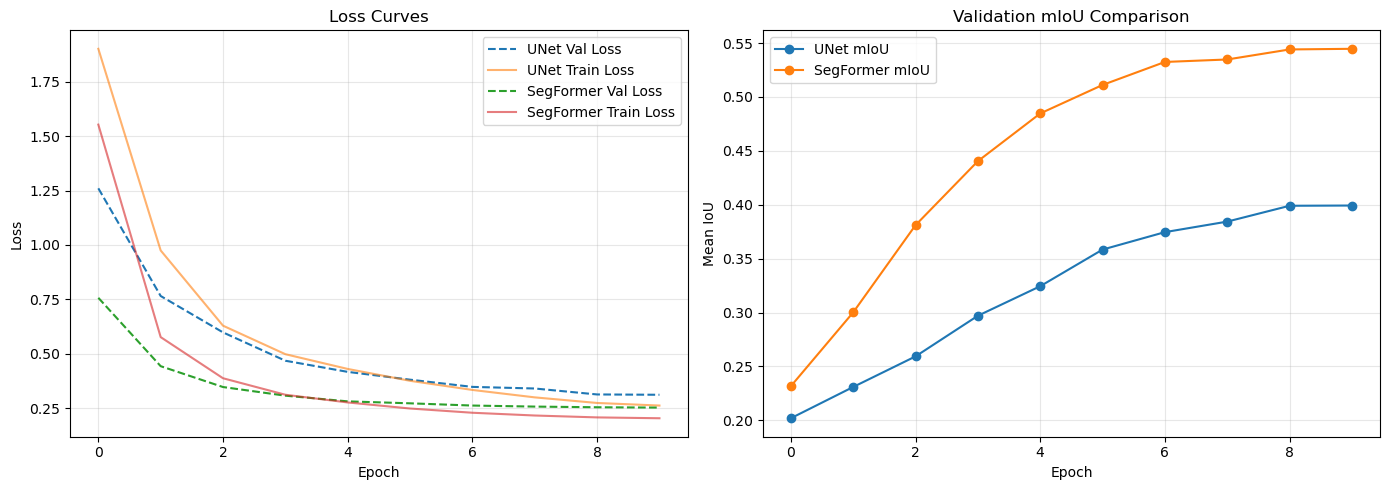

In [79]:
import matplotlib.pyplot as plt

# Summary Dictionary to DataFrame
df_res = pd.DataFrame(model_results)
print("\n--- Summary Table ---")
print(df_res)

# Plotting
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist['val_loss'], label=f"{name} Val Loss", linestyle='--')
    plt.plot(hist['train_loss'], label=f"{name} Train Loss", alpha=0.6)
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# mIoU
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist['val_miou'], label=f"{name} mIoU", marker='o')
plt.title("Validation mIoU Comparison")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

       Model  Best mIoU  Final Dice
0       UNet   0.399316    0.478657
1  SegFormer   0.544710    0.673630


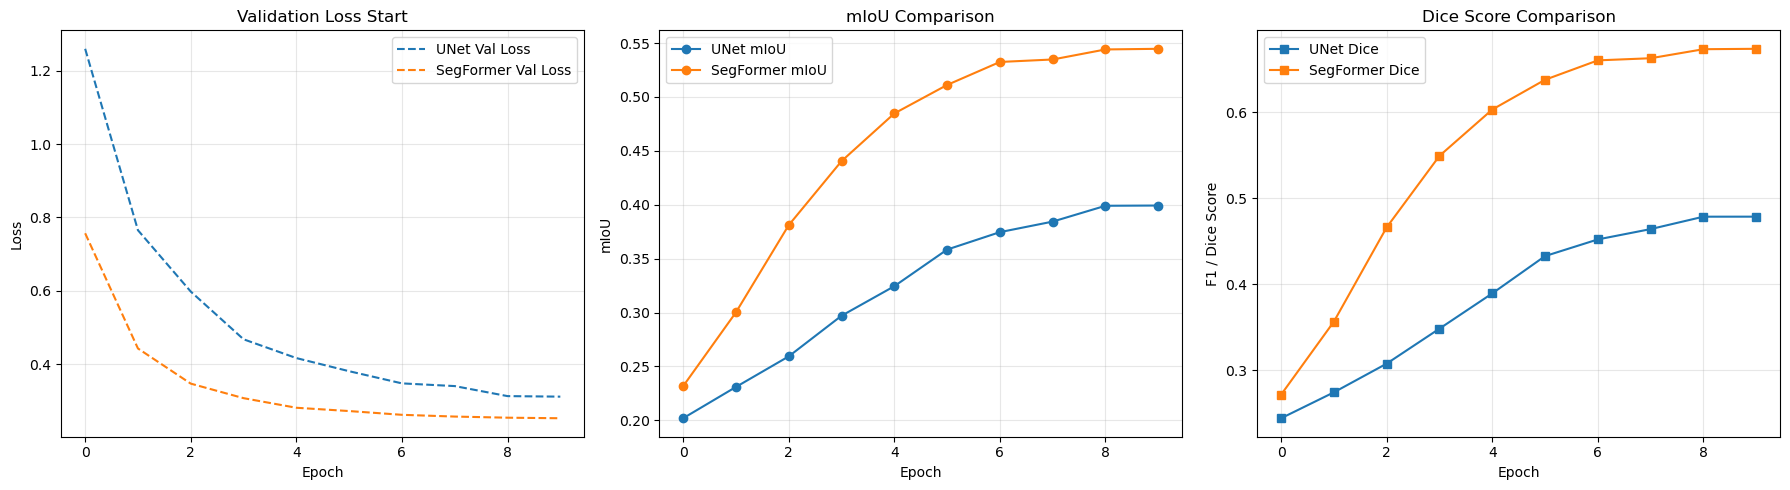

In [80]:
import matplotlib.pyplot as plt

# 1. Table
df = pd.DataFrame(results_summary)
print(df)

# 2. Plots
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
for name, h in histories.items():
    plt.plot(h['val_loss'], label=f"{name} Val Loss", linestyle='--')
plt.title("Validation Loss Start")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# mIoU
plt.subplot(1, 3, 2)
for name, h in histories.items():
    plt.plot(h['val_miou'], label=f"{name} mIoU", marker='o')
plt.title("mIoU Comparison")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.legend()
plt.grid(True, alpha=0.3)

# Dice
plt.subplot(1, 3, 3)
for name, h in histories.items():
    plt.plot(h['val_dice'], label=f"{name} Dice", marker='s')
plt.title("Dice Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("F1 / Dice Score")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visualizing Validation Predictions...


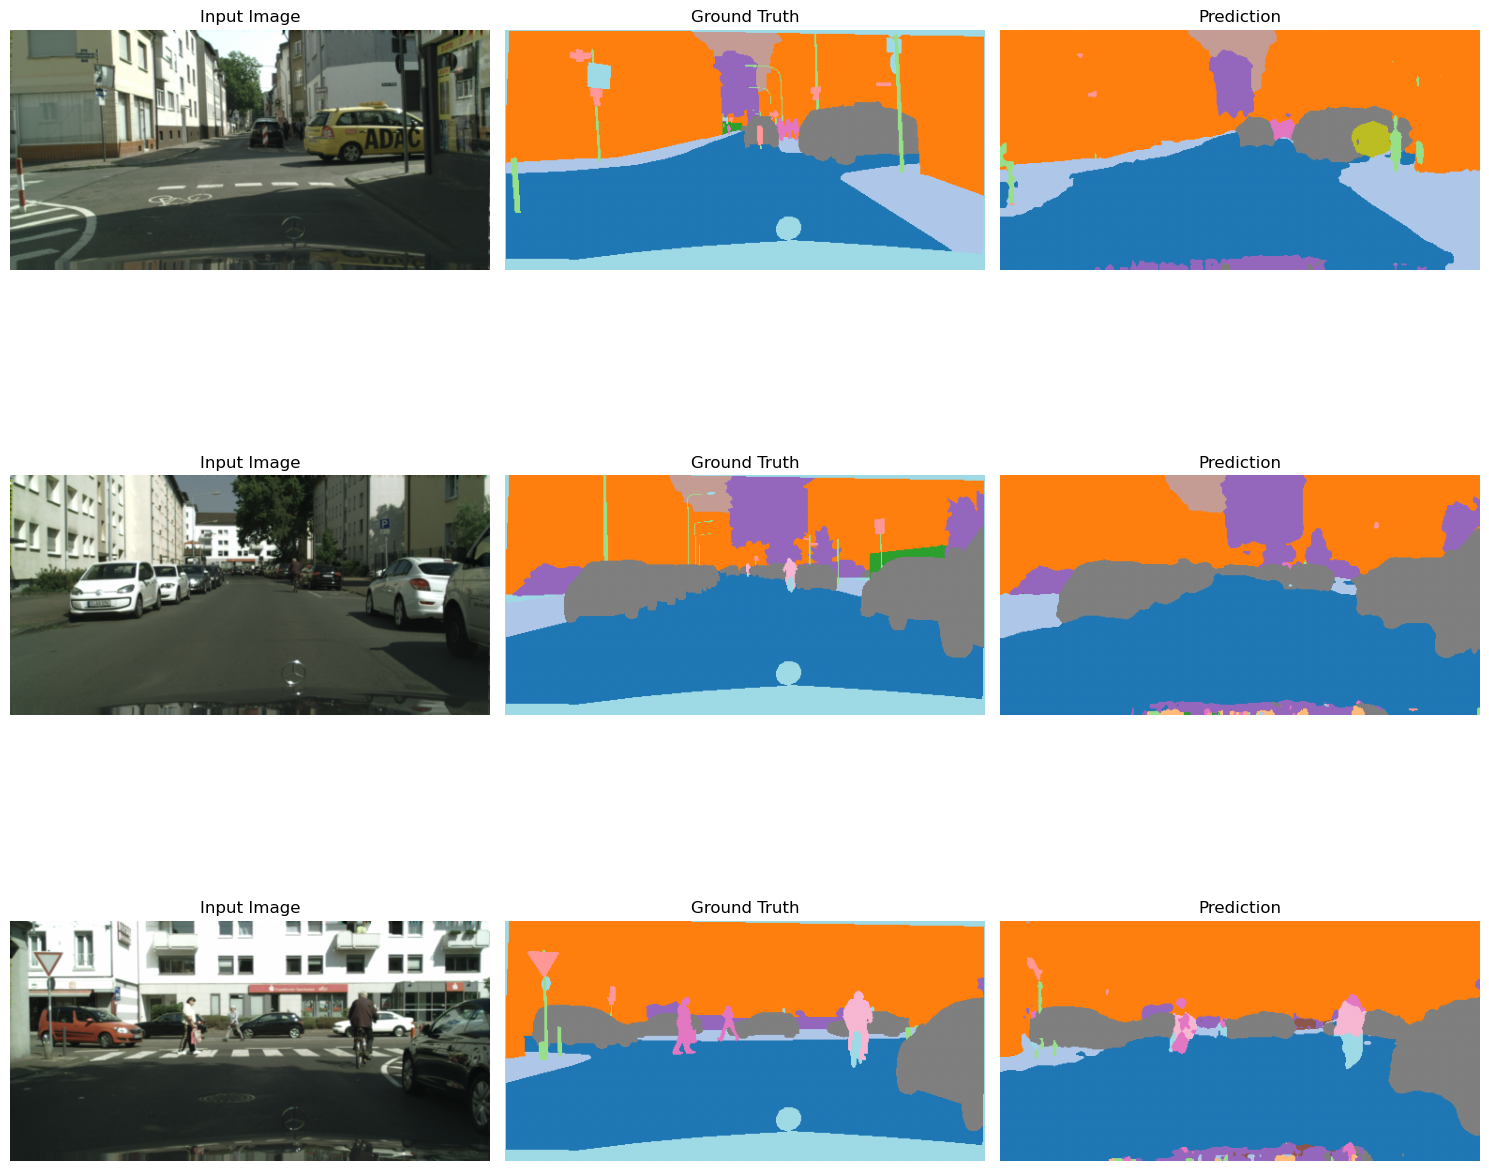


Running Final Evaluation on Test Set...


Test Loss: nan
Test mIoU: nan
Test Dice: 0.0000


In [81]:
# ==========================================
# 4. Inference & Visualization on Test Set
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    
    # Get a batch
    images, labels = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        # outputs is logits (B, C, H, W) -> argmax to get class indices
        preds = torch.argmax(outputs, dim=1) 
        
    # Move to CPU for plotting
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    
    # ImageNet mean/std for denormalization
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(min(num_samples, len(images))):
        # 1. Input Image
        img = images[i] * std + mean # Denormalize
        img = np.transpose(img, (1, 2, 0)) # CHW -> HWC
        img = np.clip(img, 0, 1)
        
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        
        # 2. Ground Truth
        plt.subplot(num_samples, 3, i*3 + 2)
        # using a colormap like 'tab20' or 'jet' helps distinguish classes
        plt.imshow(labels[i], cmap='tab20', vmin=0, vmax=18) 
        plt.title("Ground Truth")
        plt.axis('off')
        
        # 3. Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i], cmap='tab20', vmin=0, vmax=18)
        plt.title("Prediction")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# --- Load Best Model ---
# We use the SegFormer class we defined earlier
best_model = SegFormer(num_classes=NUM_CLASSES, pretrained_model_name="nvidia/mit-b0").to(device)
# Ensure this matches the filename saved in your previous cell!
best_model.load_state_dict(torch.load("best_model_SegFormer.pth"))

print("Visualizing Validation Predictions...")
visualize_predictions(best_model, val_loader, device, num_samples=3)

# --- Final Test Set Evaluation ---
print("\nRunning Final Evaluation on Test Set...")

# Initialize metrics for test
test_metrics = [
    IoUMetric(NUM_CLASSES, ignore_index=255),
    DiceScoreMetric(NUM_CLASSES, ignore_index=255)
]

# We can reuse the validate_epoch function since Test Set behavior is same as Val
test_loss, test_res = validate_epoch(best_model, test_loader, criterion, device, metrics=test_metrics)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test mIoU: {test_res['IoUMetric']:.4f}")
print(f"Test Dice: {test_res['DiceScoreMetric']:.4f}")

In [ ]:
# # https://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015
#  apo edw na doume ta 4 diaforetika metrics me IoU kai na kanoume ena apo ayta 
#  meta  inference sto kitti set an ginetai